In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
from pathlib import Path
import statistics as stats
import argparse
from torch.utils.data import Sampler
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.modules import Module
# Set device
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import accuracy_score, classification_report

# Dataset loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size depending on your dataset
    transforms.ToTensor(),
])

/home/safa/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/safa/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


In [2]:
class FewShotDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    

class PrototypicalBatchSampler(Sampler):
    def __init__(self, labels, classes_per_batch, support_per_class, queries_per_class):
        self.labels = labels
        self.classes_per_batch = classes_per_batch
        self.support_per_class = support_per_class
        self.queries_per_class = queries_per_class

        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.indices = {c: np.where(self.labels == c)[0] for c in self.classes}

    def __iter__(self):
        for _ in range(len(self)):
            batch = []
            selected_classes = np.random.choice(self.classes, self.classes_per_batch, replace=False)
            
            for c in selected_classes:
                indices = np.random.choice(self.indices[c], self.support_per_class + self.queries_per_class, replace=False)
                batch.extend(indices)

            yield batch

    def __len__(self):
        return len(self.labels) // (self.classes_per_batch * (self.support_per_class + self.queries_per_class))


    #Test with other network design


class PrototypicalNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PrototypicalNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, x):
        # Flatten the input tensor if it's not already a flat vector
        x = x.view(x.size(0), -1)  # Reshape input to [batch_size, input_size]
        return self.fc(x)
import torchvision.models as models

class ResnetPrototypicalNetwork(nn.Module):
    def __init__(self,input_size, hidden_size):
        super(ResnetPrototypicalNetwork, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        
        # Remove the fully connected layer (classifier) to use as a feature extractor
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Flatten the output to [batch_size, 512] before passing to the linear layer
        self.additional_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, hidden_size)  # Adjust the number here to match ResNet's output
        )
        

    def forward(self, x):
        # Extract features using the ResNet backbone
        x = self.features(x)
        
        # Pass through any additional layers
        embedding = self.additional_layers(x)
        return embedding

class Resnet34PrototypicalNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Resnet34PrototypicalNetwork, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet34(pretrained=True)
        
        # Remove the fully connected layer (classifier) to use as a feature extractor
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Flatten the output to [batch_size, 512] before passing to the linear layer
        self.additional_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, hidden_size)  # Adjust the number here to match ResNet's output
        )
        

    def forward(self, x):
        # Extract features using the ResNet backbone
        x = self.features(x)
        
        # Pass through any additional layers
        embedding = self.additional_layers(x)
        return embedding
    
class VGGPrototypicalNetwork(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(VGGPrototypicalNetwork, self).__init__()
        # Load a pre-trained VGG model
        self.vgg = models.vgg16(pretrained=True)
        
        # Remove the classifier section to use VGG as a feature extractor
        # Features before the classifier in VGG models are accessible via 'features'
        self.features = self.vgg.features
        
        # The VGG model outputs a feature map of size 512x7x7 (for input size 224x224)
        # We'll apply AdaptiveAvgPool2d to reduce it to a 512-dimensional vector per image
        self.avgpool = self.vgg.avgpool

        # Flatten the output and pass it through a new classifier
        # Adjust the input size of the linear layer to match VGG's output (512 after pooling)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, hidden_size),  # Use 512 as the input size if using AdaptiveAvgPool2d
            nn.ReLU(True),
            nn.Linear(hidden_size, num_classes)  # Final layer for few-shot learning classification
        )

    def forward(self, x):
        # Extract features using the VGG backbone
        x = self.features(x)
        
        # Apply the VGG's original average pooling
        x = self.avgpool(x)

        # Pass through the new classifier
        x = self.classifier(x)
        return x

    
class PrototypicalNetwork2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PrototypicalNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, x):
        return self.fc(x)


    # coding=utf-8

#################################################################

################################################################3

class PrototypicalLoss(Module):
    '''
    Loss class deriving from Module for the prototypical loss function defined below
    '''
    def __init__(self, n_support):
        super(PrototypicalLoss, self).__init__()
        self.n_support = n_support

    def forward(self, input, target):
        return prototypical_loss(input, target)#, self.n_support)


def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)



def prototypical_loss(input, target):#, n_support):
    '''
    Inspired by https://github.com/jakesnell/prototypical-networks/blob/master/protonets/models/few_shot.py

    Compute the barycentres by averaging the features of n_support
    samples for each class in target, computes then the distances from each
    samples' features to each one of the barycentres, computes the
    log_probability for each n_query samples for each one of the current
    classes, of appartaining to a class c, loss and accuracy are then computed
    and returned
    Args:
    - input: the model output for a batch of samples
    - target: ground truth for the above batch of samples
    - n_support: number of samples to keep in account when computing
      barycentres, for each one of the current classes
    '''
    target_cpu = target.to(device)
    input_cpu = input.to(device)

    def supp_idxs(c):
        # FIXME when torch will support where as np
        return target_cpu.eq(c).nonzero()[:n_support].squeeze(1)

    # FIXME when torch.unique will be available on cuda too
    classes = torch.unique(target_cpu)
    n_classes = len(classes)
    #print('n_classes:',n_classes)
    # FIXME when torch will support where as np
    # assuming n_query, n_target constants
    n_query = target_cpu.eq(classes[0].item()).sum().item() - n_support
    #print('n_query:',n_query)
    support_idxs = list(map(supp_idxs, classes))

    prototypes = torch.stack([input_cpu[idx_list].mean(0) for idx_list in support_idxs])
    # FIXME when torch will support where as np
    query_idxs = torch.stack(list(map(lambda c: target_cpu.eq(c).nonzero()[n_support:], classes))).view(-1)

    query_samples = input.to(device)[query_idxs]
    dists = euclidean_dist(query_samples, prototypes)

    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1)

    target_inds = torch.arange(0, n_classes, device=device)
    target_inds = target_inds.view(n_classes, 1, 1)
    target_inds = target_inds.expand(n_classes, n_query, 1).long()
   # print('target_inds:',target_inds)

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    #print('y_hat',y_hat)
    acc_val = y_hat.eq(target_inds.squeeze(2)).float().mean()
    target_inds = target_inds.squeeze(2)
    
    
    return loss_val,  acc_val

def compute_prototypes(support_embeddings, support_labels, n_classes):
    """Compute class prototypes from support set embeddings."""
    prototypes = []
    for i in range(n_classes):
        # Extract embeddings belonging to class i
        class_embeddings = support_embeddings[support_labels == i]
        # Compute the mean of these embeddings
        prototype = class_embeddings.mean(0)
        prototypes.append(prototype)
    return torch.stack(prototypes)

def classify_embeddings(query_embeddings, prototypes):
    """Classify query embeddings based on the nearest class prototype."""
    # Calculate the distances from each query embedding to each prototype
    distances = euclidean_dist(query_embeddings, prototypes)

    # Find the index of the nearest prototype for each query embedding
    nearest_prototype_indices = distances.argmin(1)

    soft_assignments = F.softmax(-distances, dim=1) 
    
    return nearest_prototype_indices,soft_assignments

def get_support_set_embeddings(support_loader, proto_net):
    """Obtain embeddings and labels from the support set."""
    support_embeddings = []
    support_labels = []

    proto_net.eval()
    with torch.no_grad():
        for features, labels in support_loader:  # support_loader loads the support set
            
            features = features.to(device)
            optimizer.zero_grad()
            #dim_features, _ = dim_model(features)
        
            embeddings = proto_net(features)
            support_embeddings.append(embeddings.cpu().numpy())
            support_labels.append(labels.cpu().numpy())
        return np.concatenate(support_embeddings, axis=0), np.concatenate(support_labels, axis=0)


In [3]:

dataset = ImageFolder(root='Axial', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

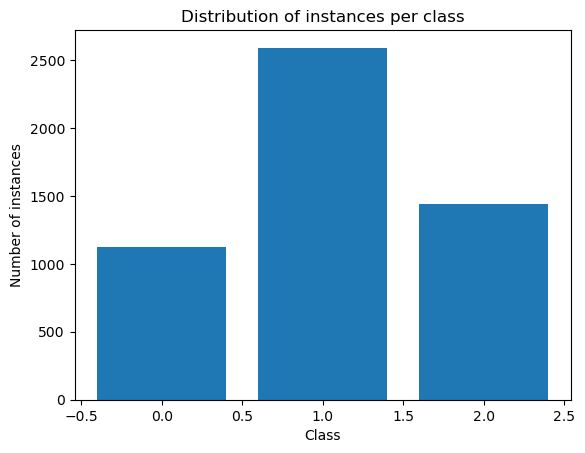

In [5]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
# assuming `your_dataset` is an instance of a class that extends torch.utils.data.Dataset

# Create your DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Calculate the number of instances in each class
class_counts = {}
for _, label in dataloader:
    label = label.item()
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Sort the counts for better visualization
sorted_counts = dict(sorted(class_counts.items()))

# Create a bar plot
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Distribution of instances per class')
plt.show()


In [6]:

encoded_features = []
true_labels = []  # Assuming you have some labels

with torch.no_grad():
    for images, labels in data_loader:  # DataLoader for your labeled subset
        images = images.to(device)
        
        encoded_features.extend(images.cpu().numpy())
        true_labels.extend(labels.numpy())

In [7]:
num_classes = 3
X_train, X_test, y_train, y_test = train_test_split(encoded_features, true_labels, test_size=0.6, random_state=42)

In [8]:
import pickle

# Assuming X_train, X_test, y_train, y_test are your data
data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

with open('train_test_data.pkl', 'wb') as file:
    pickle.dump(data, file)


In [10]:
# Assuming 'data' and 'labels' are your datasets
train_dataset = FewShotDataset(X_train, y_train)
test_dataset = FewShotDataset(X_test, y_test)

train_sampler = PrototypicalBatchSampler(y_train, classes_per_batch=3, support_per_class=10, queries_per_class=5)
test_sampler = PrototypicalBatchSampler(y_test, classes_per_batch=3, support_per_class=10, queries_per_class=5)

#train_sampler = PrototypicalBatchSampler(X_train, y_train, classes_per_batch=4, support_per_class=10, queries_per_class=5)
#test_sampler = PrototypicalBatchSampler(X_test, y_test, classes_per_batch=4, support_per_class=10, queries_per_class=5)

train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler)

In [11]:
# Adjust the input_size to match the size of your extracted features
input_size =  224 * 224 * 3 #input_size = 64  # Replace with the actual size of your features
hidden_size = 128 #26  # 256 This can be adjusted as per your model's requirement


In [12]:
proto_net = ResnetPrototypicalNetwork(input_size, hidden_size).to(device)
# Prototypical Loss
n_support = 10  # Adjust as needed
proto_loss_fn = PrototypicalLoss(n_support).to(device)
optimizer = torch.optim.Adam(proto_net.parameters(), lr=1e-4)

/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
epoch_losses = []
epoch_accuracies = []
avg_losses_for_plot = []  # To store average losses for plotting
avg_accuracies_for_plot = []  # To store average accuracies for plotting

# Training loop  hidden_size = 26 
for epoch in range(30):
    total_loss = 0.0
    total_accuracy = 0.0
    total_batches = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()

        output = proto_net(features)
        loss, acc = proto_loss_fn(output, labels)

        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_accuracy += acc.item()
        total_batches += 1

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    
    # Store metrics
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(avg_accuracy)
    
    # Store metrics for plotting
    avg_losses_for_plot.append(avg_loss)
    avg_accuracies_for_plot.append(avg_accuracy)
    
    # Log the training progress
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}')


Epoch 0, Average Loss: 1.0368, Average Accuracy: 0.5644
Epoch 1, Average Loss: 0.2857, Average Accuracy: 0.8948
Epoch 2, Average Loss: 0.2915, Average Accuracy: 0.9067
Epoch 3, Average Loss: 0.1911, Average Accuracy: 0.9348
Epoch 4, Average Loss: 0.1423, Average Accuracy: 0.9541
Epoch 5, Average Loss: 0.1758, Average Accuracy: 0.9437
Epoch 6, Average Loss: 0.0980, Average Accuracy: 0.9630
Epoch 7, Average Loss: 0.1886, Average Accuracy: 0.9467
Epoch 8, Average Loss: 0.0797, Average Accuracy: 0.9674
Epoch 9, Average Loss: 0.0628, Average Accuracy: 0.9793
Epoch 10, Average Loss: 0.0444, Average Accuracy: 0.9807
Epoch 11, Average Loss: 0.0284, Average Accuracy: 0.9926
Epoch 12, Average Loss: 0.0177, Average Accuracy: 0.9926
Epoch 13, Average Loss: 0.0361, Average Accuracy: 0.9926
Epoch 14, Average Loss: 0.0493, Average Accuracy: 0.9881
Epoch 15, Average Loss: 0.0704, Average Accuracy: 0.9704
Epoch 16, Average Loss: 0.0287, Average Accuracy: 0.9911
Epoch 17, Average Loss: 0.0376, Average A

In [14]:
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have a DataLoader named support_loader for the support set
support_embeddings, support_labels = get_support_set_embeddings(test_loader, proto_net)
# Convert to PyTorch tensors
support_embeddings = torch.tensor(support_embeddings).to(device)
support_labels = torch.tensor(support_labels).to(device)

n_classes = 3
# Compute the prototypes
prototypes = compute_prototypes(support_embeddings, support_labels, n_classes)
# In your evaluation loop
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        query_embeddings = proto_net(features)
        predicted_labels = classify_embeddings(query_embeddings, prototypes)
proto_net.eval()  # Assuming 'proto_net' is your Prototypical Network model


from sklearn.metrics import accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # Replace eval_loader with your DataLoader for evaluation
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = proto_net(features)
        preds, soft_assignments = classify_embeddings(embeddings,prototypes)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')
print(classification_report(all_labels, all_preds, digits=4))



Accuracy: 0.9941176470588236
              precision    recall  f1-score   support

           0     0.9941    0.9990    0.9966      1020
           1     0.9931    0.9902    0.9917      1020
           2     0.9951    0.9931    0.9941      1020

    accuracy                         0.9941      3060
   macro avg     0.9941    0.9941    0.9941      3060
weighted avg     0.9941    0.9941    0.9941      3060



In [15]:
# Save the model architecture and trained parameters
torch.save(proto_net.state_dict(), "ADNI_ResNet_protonet.pth")
# Load the trained parameters
#model.load_state_dict(torch.load("trained_protonet.pth"))


## MobileNetPrototypicalNetwork

In [16]:
import torch.nn as nn
import torchvision.models as models

class MobileNetPrototypicalNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MobileNetPrototypicalNetwork, self).__init__()
        # Load a pre-trained MobileNet model
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Remove the classifier to use as a feature extractor
        # For MobileNetV2, features before the classifier are stored in 'features'
        self.features = self.mobilenet.features
        
        # MobileNetV2 outputs features of size 1280 for each image
        # Adjust the input size of the linear layer accordingly
        self.additional_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce spatial dimensions
            nn.Flatten(),
            nn.Linear(1280, 3)  # Adjust the number here to match MobileNetV2's output
        )

    def forward(self, x):
        # Extract features using the MobileNet backbone
        x = self.features(x)
        
        # Pass through additional layers
        embedding = self.additional_layers(x)
        return embedding


In [17]:
MobileNet_proto_net = MobileNetPrototypicalNetwork(input_size, hidden_size).to(device)
# Prototypical Loss
n_support = 10  # Adjust as needed
proto_loss_fn = PrototypicalLoss(n_support).to(device)
optimizer = torch.optim.Adam(MobileNet_proto_net.parameters(), lr=1e-4)
epoch_losses = []
epoch_accuracies = [] 
mobilenet_avg_losses_for_plot = []  # To store average losses for plotting
mobilenet_avg_accuracies_for_plot = []  # To store average accuracies for plotting

# Training loop  hidden_size = 26 
for epoch in range(30):
    total_loss = 0.0
    total_accuracy = 0.0
    total_batches = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        #optimizer.zero_grad()
        #output = proto_net(features)
        #loss, acc, predictions, true_labels = proto_loss_fn(output, labels)
        optimizer.zero_grad()

        # Extract features from the pre-trained DIM model
        #with torch.no_grad():
        #/    dim_features, _ = dim_model(features)

        # Now, use dim_features as the input to your ProtoNet model
        output = MobileNet_proto_net(features)
        loss, acc = proto_loss_fn(output, labels)


        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_accuracy += acc.item()
        total_batches += 1

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    
    # Store metrics
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(avg_accuracy)
    
    mobilenet_avg_losses_for_plot.append(avg_loss)
    mobilenet_avg_accuracies_for_plot.append(avg_accuracy)
    
    # Log the training progress
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}')


/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Average Loss: 0.7605, Average Accuracy: 0.6459
Epoch 1, Average Loss: 0.4018, Average Accuracy: 0.8459
Epoch 2, Average Loss: 0.2331, Average Accuracy: 0.9096
Epoch 3, Average Loss: 0.1166, Average Accuracy: 0.9615
Epoch 4, Average Loss: 0.1007, Average Accuracy: 0.9644
Epoch 5, Average Loss: 0.1021, Average Accuracy: 0.9615
Epoch 6, Average Loss: 0.0888, Average Accuracy: 0.9719
Epoch 7, Average Loss: 0.0848, Average Accuracy: 0.9763
Epoch 8, Average Loss: 0.0407, Average Accuracy: 0.9911
Epoch 9, Average Loss: 0.0336, Average Accuracy: 0.9896
Epoch 10, Average Loss: 0.0327, Average Accuracy: 0.9881
Epoch 11, Average Loss: 0.0447, Average Accuracy: 0.9881
Epoch 12, Average Loss: 0.0477, Average Accuracy: 0.9807
Epoch 13, Average Loss: 0.0744, Average Accuracy: 0.9704
Epoch 14, Average Loss: 0.0716, Average Accuracy: 0.9733
Epoch 15, Average Loss: 0.0173, Average Accuracy: 0.9911
Epoch 16, Average Loss: 0.0384, Average Accuracy: 0.9837
Epoch 17, Average Loss: 0.0440, Average A

In [18]:
# Assuming you have a DataLoader named support_loader for the support set
support_embeddings, support_labels = get_support_set_embeddings(test_loader, MobileNet_proto_net)
# Convert to PyTorch tensors
support_embeddings = torch.tensor(support_embeddings).to(device)
support_labels = torch.tensor(support_labels).to(device)

n_classes = 3
# Compute the prototypes
prototypes = compute_prototypes(support_embeddings, support_labels, n_classes)
# In your evaluation loop
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        query_embeddings = MobileNet_proto_net(features)
        predicted_labels = classify_embeddings(query_embeddings, prototypes)
MobileNet_proto_net.eval()  # Assuming 'proto_net' is your Prototypical Network model

all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # Replace eval_loader with your DataLoader for evaluation
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = MobileNet_proto_net(features)
        preds, soft_assignments = classify_embeddings(embeddings,prototypes)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')
print(classification_report(all_labels, all_preds, digits=4))



Accuracy: 0.9428104575163399
              precision    recall  f1-score   support

           0     0.9461    0.9461    0.9461      1020
           1     0.9040    0.9422    0.9227      1020
           2     0.9816    0.9402    0.9604      1020

    accuracy                         0.9428      3060
   macro avg     0.9439    0.9428    0.9431      3060
weighted avg     0.9439    0.9428    0.9431      3060



In [19]:
# Save the model architecture and trained parameters
torch.save(MobileNet_proto_net.state_dict(), "ADNI_MobileNet_proto_net.pth")
# Load the trained parameters
#model.load_state_dict(torch.load("trained_protonet.pth"))


## VGGPrototypicalNetwork

In [20]:
class VGGPrototypicalNetwork(nn.Module):
    def __init__(self, hidden_size):
        super(VGGPrototypicalNetwork, self).__init__()
        # Load a pre-trained VGG model
        self.vgg = models.vgg16(pretrained=True)
        
        # Use VGG as a feature extractor
        self.features = self.vgg.features
        self.avgpool = self.vgg.avgpool

        # Flatten the output and pass it through additional layers for feature embedding
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, hidden_size),  # Embedding layer
            nn.ReLU(True)
            # Removed the final classification layer to focus on embeddings
        )

    def forward(self, x):
        # Extract features using the VGG backbone
        x = self.features(x)
        x = self.avgpool(x)

        # Generate embeddings suitable for prototypical network
        embedding = self.embedding(x)
        return embedding


In [21]:
proto_net = VGGPrototypicalNetwork(128).to(device)
# Prototypical Loss
n_support = 10  # Adjust as needed
proto_loss_fn = PrototypicalLoss(n_support).to(device)
optimizer = torch.optim.Adam(proto_net.parameters(), lr=1e-4)
epoch_losses = []
epoch_accuracies = [] 
vgg_avg_losses_for_plot = []
vgg_avg_accuracies_for_plot = []


# Training loop  hidden_size = 26 
for epoch in range(30):
    total_loss = 0.0
    total_accuracy = 0.0
    total_batches = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        #optimizer.zero_grad()
        #output = proto_net(features)
        #loss, acc, predictions, true_labels = proto_loss_fn(output, labels)
        optimizer.zero_grad()

        # Extract features from the pre-trained DIM model
        #with torch.no_grad():
        #/    dim_features, _ = dim_model(features)

        # Now, use dim_features as the input to your ProtoNet model
        output = proto_net(features)
        #print(output.shape)
        loss, acc = proto_loss_fn(output, labels)


        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_accuracy += acc.item()
        total_batches += 1

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    
    # Store metrics
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(avg_accuracy)
    vgg_avg_losses_for_plot.append(avg_loss)
    vgg_avg_accuracies_for_plot.append(avg_accuracy)
    
    # Log the training progress
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}')


/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Average Loss: 0.8904, Average Accuracy: 0.5807
Epoch 1, Average Loss: 0.6094, Average Accuracy: 0.7719
Epoch 2, Average Loss: 0.3823, Average Accuracy: 0.8548
Epoch 3, Average Loss: 0.3516, Average Accuracy: 0.8770
Epoch 4, Average Loss: 0.1880, Average Accuracy: 0.9363
Epoch 5, Average Loss: 0.1827, Average Accuracy: 0.9200
Epoch 6, Average Loss: 0.1509, Average Accuracy: 0.9615
Epoch 7, Average Loss: 0.1730, Average Accuracy: 0.9481
Epoch 8, Average Loss: 0.1012, Average Accuracy: 0.9600
Epoch 9, Average Loss: 0.1470, Average Accuracy: 0.9585
Epoch 10, Average Loss: 0.0874, Average Accuracy: 0.9763
Epoch 11, Average Loss: 0.0963, Average Accuracy: 0.9630
Epoch 12, Average Loss: 0.0671, Average Accuracy: 0.9704
Epoch 13, Average Loss: 0.0742, Average Accuracy: 0.9733
Epoch 14, Average Loss: 0.0460, Average Accuracy: 0.9852
Epoch 15, Average Loss: 0.0867, Average Accuracy: 0.9733
Epoch 16, Average Loss: 0.0652, Average Accuracy: 0.9807
Epoch 17, Average Loss: 0.0723, Average A

In [22]:
# Assuming you have a DataLoader named support_loader for the support set
support_embeddings, support_labels = get_support_set_embeddings(test_loader,proto_net)
# Convert to PyTorch tensors
support_embeddings = torch.tensor(support_embeddings).to(device)
support_labels = torch.tensor(support_labels).to(device)

n_classes = 3
# Compute the prototypes
prototypes = compute_prototypes(support_embeddings, support_labels, n_classes)
# In your evaluation loop
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        query_embeddings = proto_net(features)
        predicted_labels = classify_embeddings(query_embeddings, prototypes)
proto_net.eval()  # Assuming 'proto_net' is your Prototypical Network model

all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # Replace eval_loader with your DataLoader for evaluation
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = proto_net(features)
        preds, soft_assignments = classify_embeddings(embeddings,prototypes)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')
print(classification_report(all_labels, all_preds, digits=4))



Accuracy: 0.9705882352941176
              precision    recall  f1-score   support

           0     0.9861    0.9716    0.9788      1020
           1     0.9712    0.9578    0.9645      1020
           2     0.9552    0.9824    0.9686      1020

    accuracy                         0.9706      3060
   macro avg     0.9708    0.9706    0.9706      3060
weighted avg     0.9708    0.9706    0.9706      3060



In [23]:
# Save the model architecture and trained parameters
torch.save(proto_net.state_dict(), "ADNI_vgg_proto_net.pth")
# Load the trained parameters
#model.load_state_dict(torch.load("trained_protonet.pth"))

## EfficientNetPrototypicalNetwork

In [66]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
import torchvision.models as models

class EfficientNetPrototypicalNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, efficientnet_version='b0', weights_path=None):
        super(EfficientNetPrototypicalNetwork, self).__init__()
        # Load a pre-trained EfficientNet model
        self.efficientnet = EfficientNet.from_pretrained(f'efficientnet-{efficientnet_version}', weights_path=weights_path)
        
        # Remove the classifier to use as a feature extractor
        # For EfficientNet, features before the classifier are stored in 'extract_features'
        self.features = self.efficientnet.extract_features
        
        # EfficientNet outputs features of variable size depending on the architecture
        # Adjust the input size of the linear layer accordingly
        self.additional_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce spatial dimensions
            nn.Flatten()
        )
        # The output size of EfficientNet varies depending on its architecture
        # You may need to manually specify the input size for the linear layer
        self.linear = nn.Linear(self.efficientnet._fc.in_features, hidden_size)

    def forward(self, x):
        # Extract features using the EfficientNet backbone
        x = self.features(x)
        
        # Pass through additional layers
        x = self.additional_layers(x)
        
        # Linear layer to obtain the final embedding
        embedding = self.linear(x)
        return embedding


In [67]:
proto_net = EfficientNetPrototypicalNetwork(128,3).to(device)
# Prototypical Loss
n_support = 10  # Adjust as needed
proto_loss_fn = PrototypicalLoss(n_support).to(device)
optimizer = torch.optim.Adam(proto_net.parameters(), lr=1e-4)
epoch_losses = []
epoch_accuracies = [] 
eff_avg_losses_for_plot = []
eff_avg_accuracies_for_plot = []


# Training loop  hidden_size = 26 
for epoch in range(30):
    total_loss = 0.0
    total_accuracy = 0.0
    total_batches = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        output = proto_net(features)
        loss, acc = proto_loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_accuracy += acc.item()
        total_batches += 1

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    
    # Store metrics
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(avg_accuracy)
    eff_avg_losses_for_plot.append(avg_loss)
    eff_avg_accuracies_for_plot.append(avg_accuracy)

    
    # Log the training progress
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}')


Loaded pretrained weights for efficientnet-b0
Epoch 0, Average Loss: 1.0432, Average Accuracy: 0.4430
Epoch 1, Average Loss: 0.7573, Average Accuracy: 0.6578
Epoch 2, Average Loss: 0.4564, Average Accuracy: 0.8148
Epoch 3, Average Loss: 0.2845, Average Accuracy: 0.8889
Epoch 4, Average Loss: 0.1604, Average Accuracy: 0.9422
Epoch 5, Average Loss: 0.1428, Average Accuracy: 0.9556
Epoch 6, Average Loss: 0.1130, Average Accuracy: 0.9585
Epoch 7, Average Loss: 0.0721, Average Accuracy: 0.9778
Epoch 8, Average Loss: 0.0456, Average Accuracy: 0.9822
Epoch 9, Average Loss: 0.0562, Average Accuracy: 0.9822
Epoch 10, Average Loss: 0.0868, Average Accuracy: 0.9719
Epoch 11, Average Loss: 0.0465, Average Accuracy: 0.9852
Epoch 12, Average Loss: 0.0734, Average Accuracy: 0.9778
Epoch 13, Average Loss: 0.0428, Average Accuracy: 0.9822
Epoch 14, Average Loss: 0.0393, Average Accuracy: 0.9867
Epoch 15, Average Loss: 0.0446, Average Accuracy: 0.9852
Epoch 16, Average Loss: 0.0177, Average Accuracy: 0.

In [68]:
# Assuming you have a DataLoader named support_loader for the support set
support_embeddings, support_labels = get_support_set_embeddings(test_loader,proto_net)
# Convert to PyTorch tensors
support_embeddings = torch.tensor(support_embeddings).to(device)
support_labels = torch.tensor(support_labels).to(device)

n_classes = 3
# Compute the prototypes
prototypes = compute_prototypes(support_embeddings, support_labels, n_classes)
# In your evaluation loop
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        query_embeddings = proto_net(features)
        predicted_labels = classify_embeddings(query_embeddings, prototypes)
proto_net.eval()  # Assuming 'proto_net' is your Prototypical Network model

all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # Replace eval_loader with your DataLoader for evaluation
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = proto_net(features)
        preds, soft_assignments = classify_embeddings(embeddings,prototypes)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')
print(classification_report(all_labels, all_preds, digits=4))



Accuracy: 0.9803921568627451
              precision    recall  f1-score   support

           0     0.9727    0.9775    0.9751      1020
           1     0.9796    0.9873    0.9834      1020
           2     0.9891    0.9765    0.9827      1020

    accuracy                         0.9804      3060
   macro avg     0.9804    0.9804    0.9804      3060
weighted avg     0.9804    0.9804    0.9804      3060



In [75]:
# Save the model architecture and trained parameters
torch.save(proto_net.state_dict(), "ADNI_EfficientNet_protonet.pth")

## ResNet34

In [28]:
import torch.nn as nn
import torchvision.models as models

class Resnet34PrototypicalNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Resnet34PrototypicalNetwork, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet34(pretrained=True)
        
        # Remove the fully connected layer (classifier) to use as a feature extractor
        self.features = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Flatten the output to [batch_size, 512] before passing to the linear layer
        self.additional_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, hidden_size)  # Adjust the number here to match ResNet's output
        )
        

    def forward(self, x):
        # Extract features using the ResNet backbone
        x = self.features(x)
        
        # Pass through any additional layers
        embedding = self.additional_layers(x)
        return embedding


In [29]:
# Adjust the input_size to match the size of your extracted features
input_size =  224 * 224 * 3 #input_size = 64  # Replace with the actual size of your features
hidden_size = 128 #26  # 256 This can be adjusted as per your model's requirement

proto_net = Resnet34PrototypicalNetwork(input_size, hidden_size).to(device)
# Prototypical Loss
n_support = 10  # Adjust as needed
proto_loss_fn = PrototypicalLoss(n_support).to(device)
optimizer = torch.optim.Adam(proto_net.parameters(), lr=1e-4)

/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:

epoch_losses = []
epoch_accuracies = [] 
resnet34_avg_losses_for_plot = []
resnet34_avg_accuracies_for_plot = []

# Training loop  hidden_size = 26 
for epoch in range(30):
    total_loss = 0.0
    total_accuracy = 0.0
    total_batches = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        #optimizer.zero_grad()
        #output = proto_net(features)
        #loss, acc, predictions, true_labels = proto_loss_fn(output, labels)
        optimizer.zero_grad()

        # Extract features from the pre-trained DIM model
        #with torch.no_grad():
        #/    dim_features, _ = dim_model(features)

        # Now, use dim_features as the input to your ProtoNet model
        output = proto_net(features)
        loss, acc = proto_loss_fn(output, labels)


        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_accuracy += acc.item()
        total_batches += 1

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    
    # Store metrics
    epoch_losses.append(avg_loss)
    epoch_accuracies.append(avg_accuracy)
    resnet34_avg_losses_for_plot.append(avg_loss)
    resnet34_avg_accuracies_for_plot.append(avg_accuracy)
    # Log the training progress
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}')


Epoch 0, Average Loss: 1.0274, Average Accuracy: 0.6089
Epoch 1, Average Loss: 0.4449, Average Accuracy: 0.8281
Epoch 2, Average Loss: 0.3037, Average Accuracy: 0.8904
Epoch 3, Average Loss: 0.2342, Average Accuracy: 0.9141
Epoch 4, Average Loss: 0.1203, Average Accuracy: 0.9630
Epoch 5, Average Loss: 0.1408, Average Accuracy: 0.9511
Epoch 6, Average Loss: 0.0663, Average Accuracy: 0.9733
Epoch 7, Average Loss: 0.1208, Average Accuracy: 0.9615
Epoch 8, Average Loss: 0.0896, Average Accuracy: 0.9719
Epoch 9, Average Loss: 0.0362, Average Accuracy: 0.9896
Epoch 10, Average Loss: 0.0503, Average Accuracy: 0.9837
Epoch 11, Average Loss: 0.0717, Average Accuracy: 0.9837
Epoch 12, Average Loss: 0.0400, Average Accuracy: 0.9852
Epoch 13, Average Loss: 0.0249, Average Accuracy: 0.9881
Epoch 14, Average Loss: 0.0490, Average Accuracy: 0.9896
Epoch 15, Average Loss: 0.0198, Average Accuracy: 0.9926
Epoch 16, Average Loss: 0.0911, Average Accuracy: 0.9704
Epoch 17, Average Loss: 0.0550, Average A

In [31]:
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have a DataLoader named support_loader for the support set
support_embeddings, support_labels = get_support_set_embeddings(test_loader, proto_net)
# Convert to PyTorch tensors
support_embeddings = torch.tensor(support_embeddings).to(device)
support_labels = torch.tensor(support_labels).to(device)

n_classes = 3
# Compute the prototypes
prototypes = compute_prototypes(support_embeddings, support_labels, n_classes)
# In your evaluation loop
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        query_embeddings = proto_net(features)
        predicted_labels = classify_embeddings(query_embeddings, prototypes)
proto_net.eval()  # Assuming 'proto_net' is your Prototypical Network model


from sklearn.metrics import accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # Replace eval_loader with your DataLoader for evaluation
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = proto_net(features)
        preds, soft_assignments = classify_embeddings(embeddings,prototypes)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')
print(classification_report(all_labels, all_preds, digits=4))

 

Accuracy: 0.9875816993464053
              precision    recall  f1-score   support

           0     0.9931    0.9882    0.9907      1020
           1     0.9797    0.9941    0.9869      1020
           2     0.9901    0.9804    0.9852      1020

    accuracy                         0.9876      3060
   macro avg     0.9876    0.9876    0.9876      3060
weighted avg     0.9876    0.9876    0.9876      3060



In [32]:
# Save the model architecture and trained parameters
torch.save(proto_net.state_dict(), "ADNI_ResNet34_protonet.pth")

## Load trained models

In [71]:
#Load models

resnet = ResnetPrototypicalNetwork(input_size, hidden_size).to(device)

resnet.load_state_dict(torch.load("ADNI_ResNet_protonet.pth"))

resnet34 = Resnet34PrototypicalNetwork(input_size, hidden_size).to(device)

resnet34.load_state_dict(torch.load("ADNI_ResNet34_protonet.pth"))

vgg = VGGPrototypicalNetwork(128).to(device)

vgg.load_state_dict(torch.load("ADNI_vgg_proto_net.pth"))

MobileNet = MobileNetPrototypicalNetwork(input_size, hidden_size).to(device)

MobileNet.load_state_dict(torch.load('ADNI_MobileNet_proto_net.pth')) 

EfficientNet = EfficientNetPrototypicalNetwork(128,3).to(device)

EfficientNet.load_state_dict(torch.load("ADNI_EfficientNet_protonet.pth"))

/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/safa/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` t

<All keys matched successfully>

In [78]:
# Set the models to evaluation mode
resnet.eval()
resnet34.eval()
vgg.eval()
MobileNet.eval()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# Initialize lists to store predictions and probabilities for each model
true_labels = []

all_resnet_preds = []
all_resnet_labels = []
all_resnet_probs = []

all_resnet34_preds = []
all_resnet34_labels = []
all_resnet34_probs = []

all_vgg_preds = []
all_vgg_labels = []
all_vgg_probs = []

all_m_preds = []
all_m_labels = []
all_m_probs = []

all_eff_preds = []
all_eff_labels = []
all_eff_probs = []

n_classes = 3
 
# Assuming you have a DataLoader named support_loader for the support set
resnet_support_embeddings, resnet_support_labels = get_support_set_embeddings(test_loader, resnet)
# Convert to PyTorch tensors
resnet_support_embeddings = torch.tensor(resnet_support_embeddings).to(device)
resnet_support_labels = torch.tensor(resnet_support_labels).to(device)
# Compute the prototypes
resnet_prototypes = compute_prototypes(resnet_support_embeddings, resnet_support_labels, n_classes)



# Assuming you have a DataLoader named support_loader for the support set
resnet34_support_embeddings, resnet34_support_labels = get_support_set_embeddings(test_loader, resnet34)
# Convert to PyTorch tensors
resnet34_support_embeddings = torch.tensor(resnet34_support_embeddings).to(device)
resnet34_support_labels = torch.tensor(resnet34_support_labels).to(device)
# Compute the prototypes
resnet34_prototypes = compute_prototypes(resnet34_support_embeddings, resnet34_support_labels, n_classes)


# Assuming you have a DataLoader named support_loader for the support set
vgg_support_embeddings, vgg_support_labels = get_support_set_embeddings(test_loader, vgg)
# Convert to PyTorch tensors
vgg_support_embeddings = torch.tensor(vgg_support_embeddings).to(device)
vgg_support_labels = torch.tensor(vgg_support_labels).to(device)
# Compute the prototypes
vgg_prototypes = compute_prototypes(vgg_support_embeddings, vgg_support_labels, n_classes)


# Assuming you have a DataLoader named support_loader for the support set
m_support_embeddings, m_support_labels = get_support_set_embeddings(test_loader, MobileNet)
# Convert to PyTorch tensors
m_support_embeddings = torch.tensor(m_support_embeddings).to(device)
m_support_labels = torch.tensor(m_support_labels).to(device)
# Compute the prototypes
m_prototypes = compute_prototypes(m_support_embeddings, m_support_labels, n_classes)


# Assuming you have a DataLoader named support_loader for the support set
eff_support_embeddings, eff_support_labels = get_support_set_embeddings(test_loader, proto_net)
# Convert to PyTorch tensors
eff_support_embeddings = torch.tensor(eff_support_embeddings).to(device)
eff_support_labels = torch.tensor(eff_support_labels).to(device)
# Compute the prototypes
eff_prototypes = compute_prototypes(eff_support_embeddings, eff_support_labels, n_classes)


# In your evaluation loop
with torch.no_grad():
    
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        resnet_query_embeddings = resnet(features)
        preds, soft_assignments = classify_embeddings(resnet_query_embeddings, resnet_prototypes)
        all_resnet_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_resnet_labels.extend(labels.cpu().numpy())
        all_resnet_probs.extend(soft_assignments.cpu().numpy())  # Collect soft assignment probabilities

        
        resnet34_query_embeddings = resnet34(features)
        preds, soft_assignments = classify_embeddings(resnet34_query_embeddings, resnet34_prototypes)
        all_resnet34_preds.extend(preds.cpu().numpy())
        all_resnet34_labels.extend(labels.cpu().numpy())
        all_resnet34_probs.extend(soft_assignments.cpu().numpy())  # Collect soft assignment probabilities

        vgg_query_embeddings = vgg(features)
        preds, soft_assignments = classify_embeddings(vgg_query_embeddings, vgg_prototypes)
        all_vgg_preds.extend(preds.cpu().numpy())
        all_vgg_labels.extend(labels.cpu().numpy())
        all_vgg_probs.extend(soft_assignments.cpu().numpy())  # Collect soft assignment probabilities

        m_query_embeddings = MobileNet(features)
        preds, soft_assignments = classify_embeddings(m_query_embeddings, m_prototypes)
        all_m_preds.extend(preds.cpu().numpy())
        all_m_labels.extend(labels.cpu().numpy())
        all_m_probs.extend(soft_assignments.cpu().numpy())  # Collect soft assignment probabilities

        eff_query_embeddings = proto_net(features)
        preds, soft_assignments = classify_embeddings(eff_query_embeddings, eff_prototypes)
        all_eff_preds.extend(preds.cpu().numpy())
        all_eff_labels.extend(labels.cpu().numpy())
        all_eff_probs.extend(soft_assignments.cpu().numpy())  # Collect soft assignment probabilities



In [81]:
# Calculate accuracy and print results for ResNet
accuracy_resnet = accuracy_score(all_resnet_labels, all_resnet_preds)
print("ResNet:")
print(f'Accuracy: {accuracy_resnet}')
print(classification_report(all_resnet_labels, all_resnet_preds, digits=4))

# Calculate accuracy and print results for ResNet34
accuracy_resnet34 = accuracy_score(all_resnet_labels, all_resnet34_preds)
print("\n ResNet34:")
print(f'Accuracy: {accuracy_resnet34}')
print(classification_report(all_resnet_labels, all_resnet34_preds, digits=4))

# Calculate accuracy and print results for VGG
accuracy_vgg = accuracy_score(all_resnet_labels, all_vgg_preds)
print("\n VGG:")
print(f'Accuracy: {accuracy_vgg}')
print(classification_report(all_resnet_labels, all_vgg_preds, digits=4))

# Calculate accuracy and print results for MobileNet
accuracy = accuracy_score(all_m_labels, all_m_preds)
print("\n MobileNet:")
print(f'Accuracy: {accuracy}')
print(classification_report(all_m_labels, all_m_preds, digits=4))


# Calculate accuracy and print results for MobileNet
accuracy = accuracy_score(all_eff_labels, all_eff_preds)
print("\n EfficientNet:")
print(f'Accuracy: {accuracy}')
print(classification_report(all_eff_labels, all_eff_preds, digits=4))



ResNet:
Accuracy: 0.9921568627450981
              precision    recall  f1-score   support

           0     0.9883    0.9961    0.9922      1020
           1     0.9950    0.9833    0.9892      1020
           2     0.9932    0.9971    0.9951      1020

    accuracy                         0.9922      3060
   macro avg     0.9922    0.9922    0.9921      3060
weighted avg     0.9922    0.9922    0.9921      3060


 ResNet34:
Accuracy: 0.9836601307189542
              precision    recall  f1-score   support

           0     0.9824    0.9824    0.9824      1020
           1     0.9854    0.9941    0.9898      1020
           2     0.9832    0.9745    0.9788      1020

    accuracy                         0.9837      3060
   macro avg     0.9837    0.9837    0.9836      3060
weighted avg     0.9837    0.9837    0.9836      3060


 VGG:
Accuracy: 0.9758169934640523
              precision    recall  f1-score   support

           0     0.9823    0.9794    0.9809      1020
           1   

In [82]:
from scipy import stats
true_labels = all_resnet_preds
# Predict labels with models
labels = []
labels.append(all_resnet_preds)
labels.append(all_resnet34_preds)
labels.append(all_vgg_preds)
labels.append(all_m_preds)
labels.append(all_eff_preds)
labels=np.asarray(labels)
x=labels.T
labels = np.squeeze(x)
###Mode Pdrediction
mode_info = stats.mode(labels, axis = 1)
f = np.squeeze(mode_info[0]) 

In [83]:
accuracy=accuracy_score(true_labels, f)
print("Hard Voting\n Accuracy: ", accuracy)
print(classification_report(true_labels, f, digits=4))


Hard Voting
 Accuracy:  0.9921568627450981
              precision    recall  f1-score   support

           0     0.9941    0.9912    0.9927      1028
           1     0.9843    0.9940    0.9891      1008
           2     0.9980    0.9912    0.9946      1024

    accuracy                         0.9922      3060
   macro avg     0.9922    0.9922    0.9921      3060
weighted avg     0.9922    0.9922    0.9922      3060



In [84]:
# Assuming you have a PyTorch dataset object named 'dataset'
classes = dataset.classes
class_names=['AD','CI','CN']
class_names

['AD', 'CI', 'CN']

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, f)

# Normalize confusion matrix
conf_matrix_norm = normalize(conf_matrix, axis=1, norm='l1')

 
print(conf_matrix_norm)
# Plot normalized confusion matrix with a different colormap
#plt.figure(figsize=(5, 4))
#sns.set(font_scale=1.2)  # Adjust font scale for better readability
#plt.xlabel('Predicted Labels')
#plt.ylabel('True Labels')
#plt.title('Normalized Confusion Matrix')
#plt.show()


[[9.91245136e-01 7.78210117e-03 9.72762646e-04]
 [4.96031746e-03 9.94047619e-01 9.92063492e-04]
 [9.76562500e-04 7.81250000e-03 9.91210938e-01]]


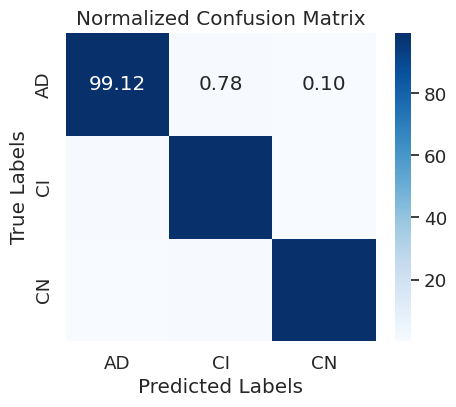

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, f)

# Normalize confusion matrix
conf_matrix_norm = normalize(conf_matrix, axis=1, norm='l1')
 
# Plot normalized confusion matrix with a different colormap
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix_norm*100, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()


## Soft Voting

In [87]:
from scipy import stats

# Collect predicted probabilities from models
probabilities = []
probabilities.append(all_resnet_probs)
probabilities.append(all_resnet34_probs)
probabilities.append(all_vgg_probs)
probabilities.append(all_m_probs)
probabilities.append(all_eff_probs)

# Convert to numpy array
probabilities = np.asarray(probabilities)

# Transpose to have shape (samples, models, classes)
probabilities = probabilities.transpose(1, 2, 0)

# Calculate average probabilities across models
average_probabilities = np.mean(probabilities, axis=2)

# Get final predictions
soft_voting_predictions = np.argmax(average_probabilities, axis=1)


In [88]:
accuracy=accuracy_score(all_resnet_labels, soft_voting_predictions)
print("Soft Voting\n Accuracy: ", accuracy)
print(classification_report(all_resnet_labels, soft_voting_predictions, digits=4))

Soft Voting
 Accuracy:  0.9986928104575163
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1020
           1     0.9961    1.0000    0.9980      1020
           2     1.0000    0.9961    0.9980      1020

    accuracy                         0.9987      3060
   macro avg     0.9987    0.9987    0.9987      3060
weighted avg     0.9987    0.9987    0.9987      3060



[[1.         0.         0.        ]
 [0.         1.         0.        ]
 [0.         0.00392157 0.99607843]]


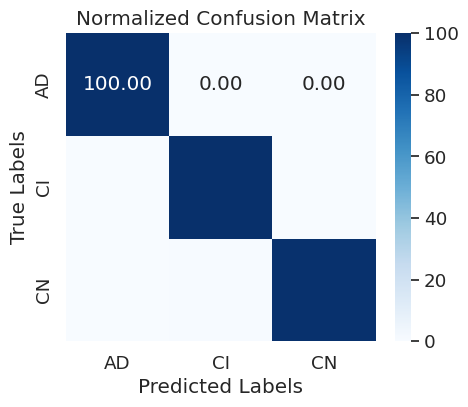

In [89]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_resnet_labels, soft_voting_predictions)

# Normalize confusion matrix
conf_matrix_norm = normalize(conf_matrix, axis=1, norm='l1')
print(conf_matrix_norm)
# Define class labels
classes = class_names

# Plot normalized confusion matrix with a different colormap
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix_norm*100, annot=True, cmap='Blues', fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')

plt.savefig('CM99.png')
plt.show()

## Visualize Embeddings

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE



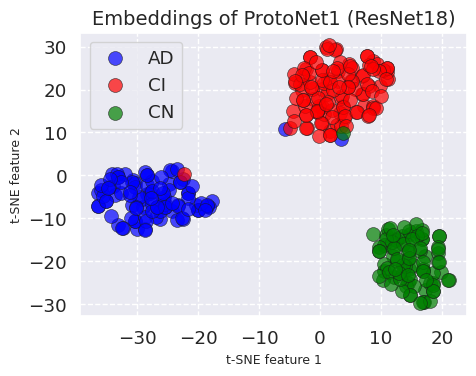

In [51]:
 
# Assuming proto_net is your Prototypical Network
resnet.eval()  # Set the model to evaluation mode
 
embeddings = []
labels = []

with torch.no_grad():
    for features, batch_labels in test_loader:  # data_loader is your DataLoader
        features = features.to(device)
        #dim_features, _ = dim_model(features) 
        batch_embeddings = resnet(features)  # Get the embeddings
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)
 
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1, random_state=42)

 # Apply t-SNE transformation
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(X_test)

import seaborn as sns
palette = sns.color_palette(['blue', 'red', 'green', 'orange'])
# Define the marker styles if desired
markers = ['o']
# Plotting
plt.figure(figsize=(5, 4))
# Use seaborn to get a nicer plot
# Scatter plot for each class using the color palette
for i, color in zip(range(len(class_names)), palette):
    indices = y_test == i
    sns.scatterplot(x=embeddings_2d[indices , 0], y=embeddings_2d[indices , 1], 
                    label=f'{class_names[i]}', color=color, s=100, 
                    alpha=0.7, edgecolor='k', linewidth=0.5, marker=markers[i % len(markers)])

# Improving the legend and placing it outside the plot
#plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large', title_fontsize='20')

# Adding title and labels with larger font sizes
plt.title('Embeddings of ProtoNet1 (ResNet18)', fontsize=14)
plt.xlabel('t-SNE feature 1', fontsize=9)
plt.ylabel('t-SNE feature 2', fontsize=9)

# Adding grid with dashed lines
plt.grid(True, linestyle='--')

# Tight layout often provides a better subplot arrangement
plt.tight_layout()
plt.savefig('emb_resnet1.png', dpi=300)

# Show the plot
plt.show()

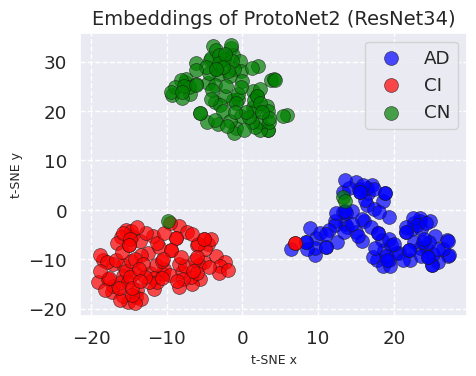

In [52]:
 # Assuming proto_net is your Prototypical Network
resnet34.eval()  # Set the model to evaluation mode

embeddings = []
labels = []

with torch.no_grad():
    for features, batch_labels in test_loader:  # data_loader is your DataLoader
        features = features.to(device)
        #dim_features, _ = dim_model(features) 
        batch_embeddings = resnet34(features)  # Get the embeddings
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1, random_state=42)

# Apply t-SNE transformation
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(X_test)

import seaborn as sns
palette = sns.color_palette(['blue', 'red', 'green', 'orange'])
# Define the marker styles if desired
markers = ['o']
# Plotting
plt.figure(figsize=(5, 4))
# Use seaborn to get a nicer plot
# Scatter plot for each class using the color palette
for i, color in zip(range(len(class_names)), palette):
    indices = y_test == i
    sns.scatterplot(x=embeddings_2d[indices , 0], y=embeddings_2d[indices , 1], 
                    label=f'{class_names[i]}', color=color, s=100, 
                    alpha=0.7, edgecolor='k', linewidth=0.5, marker=markers[i % len(markers)])

# Adding title and labels with larger font sizes
plt.title('Embeddings of ProtoNet2 (ResNet34)', fontsize=14)
plt.xlabel('t-SNE x', fontsize=9)
plt.ylabel('t-SNE y', fontsize=9)

# Adding grid with dashed lines
plt.grid(True, linestyle='--')

# Tight layout often provides a better subplot arrangement
plt.tight_layout()
plt.savefig('emb_renet34.png', dpi=300)


# Show the plot
plt.show()

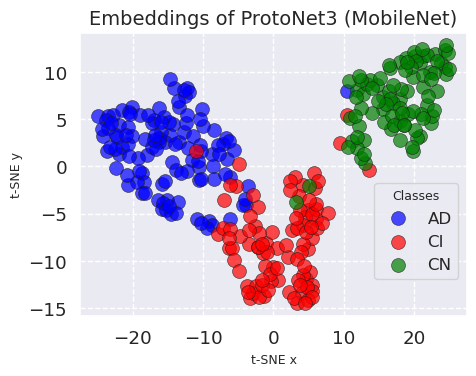

In [56]:

# Assuming you have embeddings_2d and y_test from your t-SNE and actual class data
# Here, we're going to use class_names for the legend instead of 'Class {i}'
MobileNet.eval()  # Set the model to evaluation mode

embeddings = []
labels = []

with torch.no_grad():
    for features, batch_labels in test_loader:  # data_loader is your DataLoader
        features = features.to(device)
        #dim_features, _ = dim_model(features) 
        batch_embeddings = MobileNet(features)  # Get the embeddings
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)
 
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1, random_state=42)

# Apply t-SNE transformation
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(X_test)

palette = sns.color_palette(['blue', 'red', 'green', 'orange'])
markers = ['o','o','o','o']  # Different markers for each class

# Plotting
plt.figure(figsize=(5, 4))

# Scatter plot for each class using the color palette and actual class names for the legend
for i, color in zip(range(len(class_names)), palette):
    indices = y_test == i
    sns.scatterplot(
        x=embeddings_2d[indices, 0], y=embeddings_2d[indices, 1], 
        label=class_names[i], color=color, s=100, 
        alpha=0.7, edgecolor='k', linewidth=0.5, marker=markers[i]
    )

# Improving the legend and placing it outside the plot
plt.legend(title='Classes',   bbox_to_anchor=(1, 0.5), fontsize='small', title_fontsize='9')

# Adding title and labels with larger font sizes
plt.title('Embeddings of ProtoNet3 (MobileNet)', fontsize=14)
plt.xlabel('t-SNE x', fontsize=9)
plt.ylabel('t-SNE y', fontsize=9)

# Adding grid with dashed lines
plt.grid(True, linestyle='--')

# Tight layout often provides a better subplot arrangement
plt.tight_layout()

# Save the figure
plt.savefig('emb_mobilenet.png', dpi=300)

# Show the plot
plt.show()
 

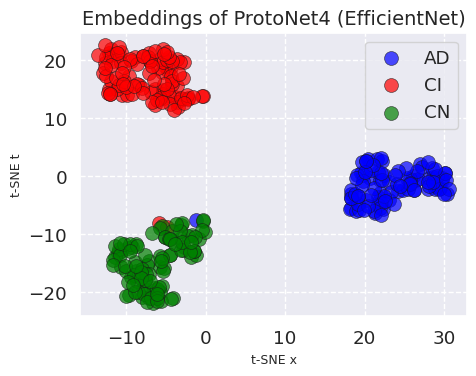

In [90]:
 # Assuming proto_net is your Prototypical Network
#efficientnet
proto_net.eval()  # Set the model to evaluation mode

embeddings = []
labels = []

with torch.no_grad():
    for features, batch_labels in test_loader:  # data_loader is your DataLoader
        features = features.to(device)
        #dim_features, _ = dim_model(features) 
        batch_embeddings = proto_net(features)  # Get the embeddings
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1, random_state=42)
 
 # Apply t-SNE transformation
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(X_test)

import seaborn as sns
palette = sns.color_palette(['blue', 'red', 'green', 'orange'])
# Define the marker styles if desired
markers = ['o']
# Plotting
plt.figure(figsize=(5, 4))
# Use seaborn to get a nicer plot
# Scatter plot for each class using the color palette
for i, color in zip(range(len(class_names)), palette):
    indices = y_test == i
    sns.scatterplot(x=embeddings_2d[indices , 0], y=embeddings_2d[indices , 1], 
                    label=f'{class_names[i]}', color=color, s=100, 
                    alpha=0.7, edgecolor='k', linewidth=0.5, marker=markers[i % len(markers)])

# Adding title and labels with larger font sizes
plt.title('Embeddings of ProtoNet4 (EfficientNet)', fontsize=14)
plt.xlabel('t-SNE x', fontsize=9)
plt.ylabel('t-SNE t', fontsize=9)



# Adding grid with dashed lines
plt.grid(True, linestyle='--')

# Tight layout often provides a better subplot arrangement
plt.tight_layout()
plt.savefig('emb_efficientnet.png', dpi=300)


# Show the plot
plt.show()

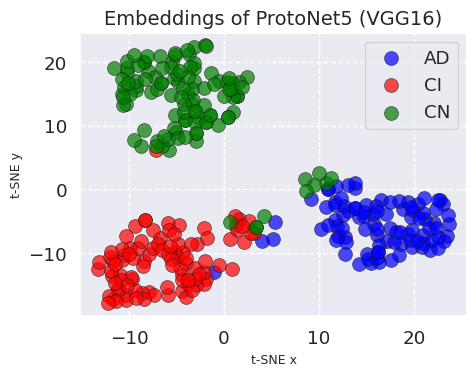

In [57]:
 # Assuming proto_net is your Prototypical Network
vgg.eval()  # Set the model to evaluation mode

embeddings = []
labels = []

with torch.no_grad():
    for features, batch_labels in test_loader:  # data_loader is your DataLoader
        features = features.to(device)
        #dim_features, _ = dim_model(features) 
        batch_embeddings = vgg(features)  # Get the embeddings
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.1, random_state=42)
 
 # Apply t-SNE transformation
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(X_test)

import seaborn as sns
palette = sns.color_palette(['blue', 'red', 'green', 'orange'])
# Define the marker styles if desired
markers = ['o']
# Plotting
plt.figure(figsize=(5, 4))
# Use seaborn to get a nicer plot
# Scatter plot for each class using the color palette
for i, color in zip(range(len(class_names)), palette):
    indices = y_test == i
    sns.scatterplot(x=embeddings_2d[indices , 0], y=embeddings_2d[indices , 1], 
                    label=f'{class_names[i]}', color=color, s=100, 
                    alpha=0.7, edgecolor='k', linewidth=0.5, marker=markers[i % len(markers)])

# Adding title and labels with larger font sizes
plt.title('Embeddings of ProtoNet5 (VGG16)', fontsize=14)
plt.xlabel('t-SNE x', fontsize=9)
plt.ylabel('t-SNE y', fontsize=9)


# Adding grid with dashed lines
plt.grid(True, linestyle='--')

# Tight layout often provides a better subplot arrangement
plt.tight_layout()
plt.savefig('emb_vgg.png', dpi=300)


# Show the plot
plt.show()